# Mie Basics

**Scott Prahl**

**January 2025**

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib.resources

if sys.platform == "emscripten":
    import piplite

    await piplite.install("miepython", deps=False)
    os.environ["MIEPYTHON_USE_JIT"] = "0"  # jupyterlite cannot use numba

import miepython as mie

## Index of Refraction and Size Parameter

When a monochromatic plane wave is incident on a sphere, it scatters and absorbs light depending on the properties of the light and sphere.  If the sphere is in a vacuum, then the complex index of refraction of the sphere is

$$
m_\mathrm{vac}= m_\mathrm{re}- j\,m_\mathrm{im}
$$

The factor $m_\mathrm{im}$ is the *index of absorption* or the *index of attenuation*.  

The dimensionless sphere size parameter for a sphere of radius $a$ is

$$
x_\mathrm{vac} = k a  = \frac{2\pi}{\lambda_\mathrm{vac}}a = \frac{2\pi a }{\lambda_\mathrm{vac}}
$$

where $\lambda_\mathrm{vac}$ is the wavelength of the light in a vacuum.

If the sphere is in a non-absorbing environment with real index $n_\mathrm{env}$ then the Mie scattering formulas can still be used, but the index of refraction of the sphere becomes 

$$
m= \frac{m_\mathrm{re}- j\,m_\mathrm{im}}{ n_\mathrm{env}}
$$

The dimensionless size parameter for a sphere includes the wavelength.  This should be the wavelength of the plane wave in the environment, thus

$$
x = \frac{2\pi a} {\lambda_\mathrm{vac}/n_\mathrm{env}}
$$

### Sign Convention
The sign of the imaginary part of the index of refraction in `miepython` is assumed negative (as shown above).  This convention is standard for atmospheric science and follows that of van de Hulst.

Starting in version 3.0.0, `miepython` silently converts positive imaginary index of refraction values to negative ones.  This may or may not be a good thing.

## Field Conventions (Near-Field)

For `miepython.field`, the electromagnetic conventions are fixed as follows:

- Harmonic convention: phasors use $\exp(-i\omega t)$ and reported fields are complex amplitudes.
- Incident wave: propagation along $+z$, electric field along $+x$, magnetic field along $+y$, with $E_0=1$.
- Spherical coordinates: $(r,\theta,\phi)$ with $\theta$ measured from $+z$ and $\phi$ measured from $+x$ toward $+y$.
- Medium handling: `lambda0` is the vacuum wavelength, `n_env` is the surrounding medium index, and `m_sphere` is the sphere index.
  The relative index is $m_\mathrm{rel}=m_\mathrm{sphere}/n_\mathrm{env}$ and the size parameter is
  $$
  x = \pi\,d_\mathrm{sphere}\,n_\mathrm{env}/\lambda_0
  $$
- Region definition: for $r>d_\mathrm{sphere}/2$, the total field is incident + scattered; for $r<d_\mathrm{sphere}/2$, the field is the internal solution only.
- Magnetic response: relative permeability is currently fixed to $\mu_r=1$ (non-magnetic media).

Boundary conditions used for validation:

- Tangential electric field is continuous: $E_{\theta,\mathrm{in}}=E_{\theta,\mathrm{out}}$ and $E_{\phi,\mathrm{in}}=E_{\phi,\mathrm{out}}$.
- Normal electric flux density is continuous: $\epsilon_\mathrm{in}E_{r,\mathrm{in}}=\epsilon_\mathrm{out}E_{r,\mathrm{out}}$.
- Tangential magnetic field is continuous: $H_{\theta,\mathrm{in}}=H_{\theta,\mathrm{out}}$ and $H_{\phi,\mathrm{in}}=H_{\phi,\mathrm{out}}$.
- Normal magnetic flux density is continuous; with $\mu_r=1$, this is equivalent to continuity of $H_r$.



### Absorption Coefficient

The imaginary part of the refractive index is a non-dimensional representation of light absorption.  This can be seen by writing out the equation for a monochromatic, plane-wave electric field

$$
\mathcal{E}(z,t) = \mathcal{E}_0 \,e^{j (\omega t - kz)}
$$

where $k$ is the complex wavenumber 

$$
k=k_\mathrm{re}-j\, k_\mathrm{im}=2\pi {{m_\mathrm{re}}\over{\lambda_\mathrm{vac}}}-j\, 2\pi \frac{m_\mathrm{im}}{\lambda_\mathrm{vac}}
$$

If $k_\mathrm{im}\ge0$ then the electric field is attenuated passing through the medium.

Thus

$$
\mathcal{E}(z,t) = \mathcal{E}_0 e^{-k_\mathrm{im}z}e^{j (\omega t - k_\mathrm{re} z)}
$$

and the corresponding time-averaged irradiance $E(z)$

$$
E(z) = {1\over2} c\epsilon |\mathcal{E}|^2 = E_0 \exp(-2k_\mathrm{im}z) = E_0 \exp(-\mu_a z)
$$

and therefore

$$
\mu_a = 2k_\mathrm{im} = 4\pi\cdot \frac{ m_\mathrm{im}}{ \lambda_\mathrm{vac}}
$$

Thus the imaginary part of the index of refraction is basically just the absorption coefficient measured in wavelengths.

In [2]:
mie.S1_S2(1.507 - 0.002j, 0.7086, np.array([-1.0], dtype=float))

(array([0.02452301+0.29539154j]), array([-0.02452301-0.29539154j]))

In [3]:
mie.S1_S2(1.507 - 0.002j, 0.7086, -1)

(array([0.02452301+0.29539154j]), array([-0.02452301-0.29539154j]))

### Complex Refractive Index of Water
Let's import and plot some data from the M.S. Thesis of D. Segelstein, "The Complex Refractive Index of Water",
University of Missouri — Kansas City, (1981) to get some sense the complex index of refraction.  The imaginary part shows absorption peaks at 3 and 6 microns, as well as the broad peak starting at 10 microns.

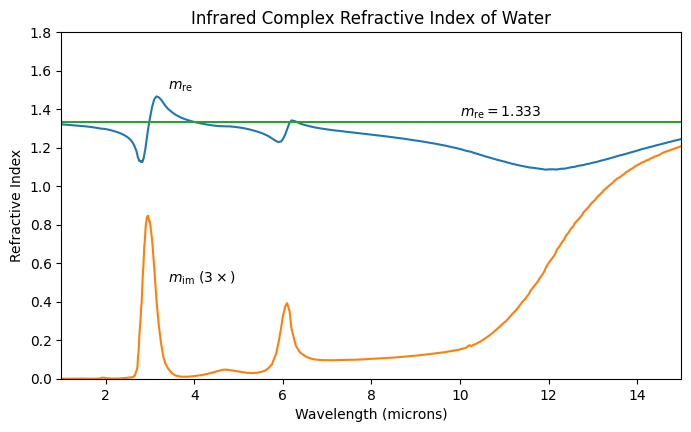

In [4]:
# import the Segelstein data
# h2o = np.genfromtxt('http://omlc.org/spectra/water/data/segelstein81_index.txt', delimiter='\t', skip_header=4)

nname = "data/segelstein81_index.txt"
ref = importlib.resources.files("miepython").joinpath(nname)
h2o = np.genfromtxt(ref, delimiter="\t", skip_header=4)

h2o_lam = h2o[:, 0]
h2o_mre = h2o[:, 1]
h2o_mim = h2o[:, 2]

plt.figure(figsize=(8, 4.5))
plt.plot(h2o_lam, h2o_mre)
plt.plot(h2o_lam, h2o_mim * 3)
plt.plot((1, 15), (1.333, 1.333))
plt.xlim((1, 15))
plt.ylim((0, 1.8))
plt.xlabel("Wavelength (microns)")
plt.ylabel("Refractive Index")
plt.annotate(r"$m_\mathrm{re}$", xy=(3.4, 1.5))
plt.annotate(r"$m_\mathrm{im}\,\,(3\times)$", xy=(3.4, 0.5))
plt.annotate(r"$m_\mathrm{re}=1.333$", xy=(10, 1.36))

plt.title("Infrared Complex Refractive Index of Water")

plt.show()

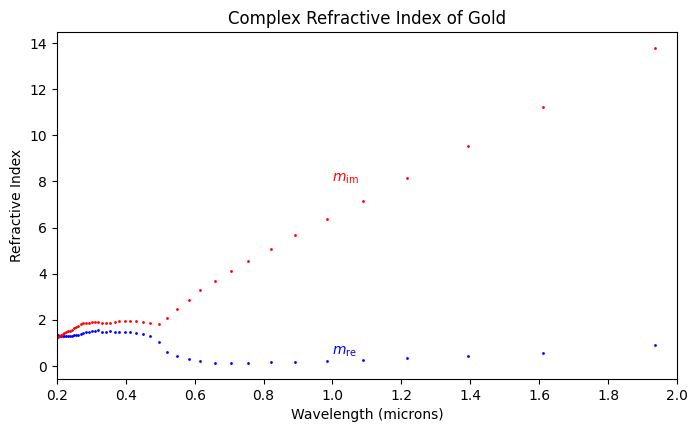

In [5]:
# import the Johnson and Christy data for gold
# https://refractiveindex.info/tmp/data/main/Au/Johnson.txt

nname = "data/Johnson.txt"
ref = importlib.resources.files("miepython").joinpath(nname)
au = np.genfromtxt(ref, delimiter="\t")

# data is stacked so need to rearrange
N = len(au) // 2
au_lam = au[1:N, 0]
au_mre = au[1:N, 1]
au_mim = au[N + 1 :, 1]

plt.figure(figsize=(8, 4.5))
plt.scatter(au_lam, au_mre, s=1, color="blue")
plt.scatter(au_lam, au_mim, s=1, color="red")
plt.xlim((0.2, 2))
plt.xlabel("Wavelength (microns)")
plt.ylabel("Refractive Index")
plt.annotate(r"$m_\mathrm{re}$", xy=(1.0, 0.5), color="blue")
plt.annotate(r"$m_\mathrm{im}$", xy=(1.0, 8), color="red")

plt.title("Complex Refractive Index of Gold")

plt.show()

### The Absorption Coefficient of Water


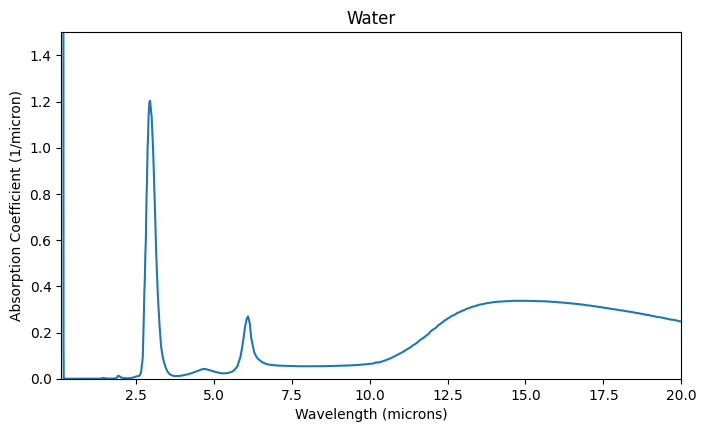

In [6]:
mua = 4 * np.pi * h2o_mim / h2o_lam

plt.figure(figsize=(8, 4.5))
plt.plot(h2o_lam, mua)
plt.xlim((0.1, 20))
plt.ylim((0, 1.5))
plt.xlabel("Wavelength (microns)")
plt.ylabel("Absorption Coefficient (1/micron)")

plt.title("Water")

plt.show()

## Size Parameters

### Size Parameter $x$
The sphere size relative to the wavelength is called the size 
parameter $x$ 
$$
x = 2\pi {r/\lambda}
$$
where $r$ is the radius of the sphere.

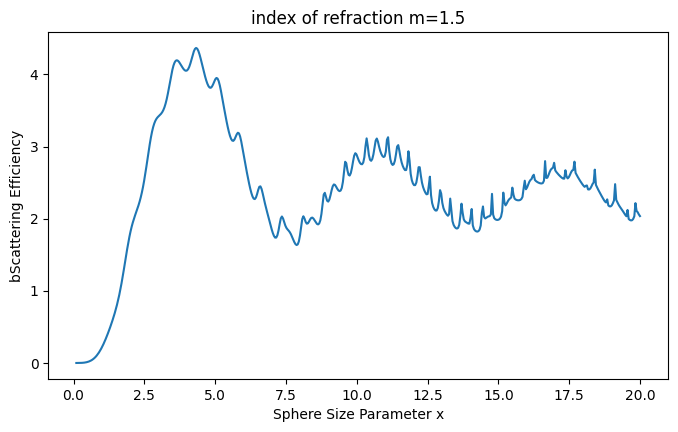

In [7]:
N = 500
m = 1.5
x = np.linspace(0.1, 20, N)  # also in microns

qext, qsca, qback, g = mie.efficiencies_mx(m, x)

plt.figure(figsize=(8, 4.5))
plt.plot(x, qsca)
plt.xlabel("Sphere Size Parameter x")
plt.ylabel("bScattering Efficiency")
plt.title("index of refraction m=1.5")
plt.show()

### Size Parameter $\rho$

The value $\rho$ is also sometimes used to facilitate comparisons for spheres with different indicies of refraction
$$
\rho = 2x(m-1)
$$
Note that when $m=1.5$ and therefore $\rho=x$. 

As can be seen in the graph below, the scattering for spheres with different indicies of refraction pretty similar when plotted against $\rho$, but no so obvious when plotted against $x$ 

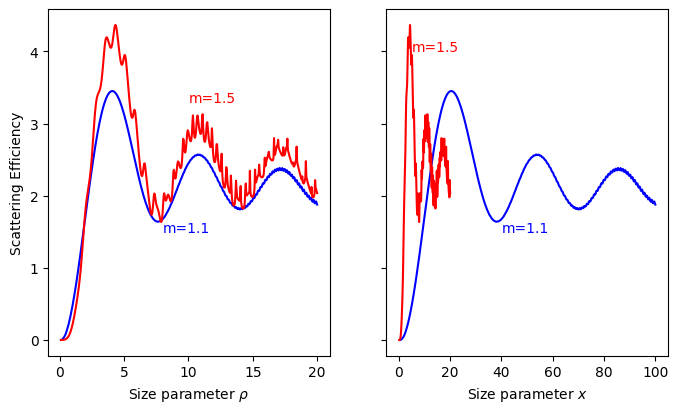

In [8]:
N = 500
m = 1.5
rho = np.linspace(0.1, 20, N)  # also in microns

m = 1.5
x15 = rho / 2 / (m - 1)
qext, sca15, qback, g = mie.efficiencies_mx(m, x15)

m = 1.1
x11 = rho / 2 / (m - 1)
qext, sca11, qback, g = mie.efficiencies_mx(m, x11)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 4.5))

ax1.plot(rho, sca11, color="blue")
ax1.plot(rho, sca15, color="red")
ax1.set_xlabel(r"Size parameter $\rho$")
ax1.set_ylabel("Scattering Efficiency")
ax1.annotate("m=1.5", xy=(10, 3.3), color="red")
ax1.annotate("m=1.1", xy=(8, 1.5), color="blue")

ax2.plot(x11, sca11, color="blue")
ax2.plot(x15, sca15, color="red")
ax2.set_xlabel(r"Size parameter $x$")
ax2.annotate("m=1.5", xy=(5, 4), color="red")
ax2.annotate("m=1.1", xy=(40, 1.5), color="blue")

plt.show()

## Embedded spheres

The short answer is that everything just scales.  

Specifically, divide the index of the sphere $m$ by the index of the surrounding material to get a relative index $m'$

$$
m' =\frac{m}{n_\mathrm{surroundings}}
$$

The wavelength in the surrounding medium $\lambda'$ is also altered

$$
\lambda' = \frac{\lambda_\mathrm{vacuum}}{n_\mathrm{surroundings}}
$$

Thus, the relative size parameter $x'$ becomes

$$
x' = \frac{2 \pi r} {\lambda'}= \frac{2 \pi r n_\mathrm{surroundings}}{ \lambda_\mathrm{vacuum}}
$$

Scattering calculations for an embedded sphere uses $m'$ and $x'$ instead of $m$ and $x$.

If the spheres are air ($m=1$) bubbles in water ($m=4/3$), then the relative index of refraction will be about 

$$
m' =  m/n_\mathrm{water} \approx 1.0/(4/3) = 3/4 = 0.75
$$

Here we call `mie.efficiencies_mx(m, x)` since we have calculated both `m` and `x` already.

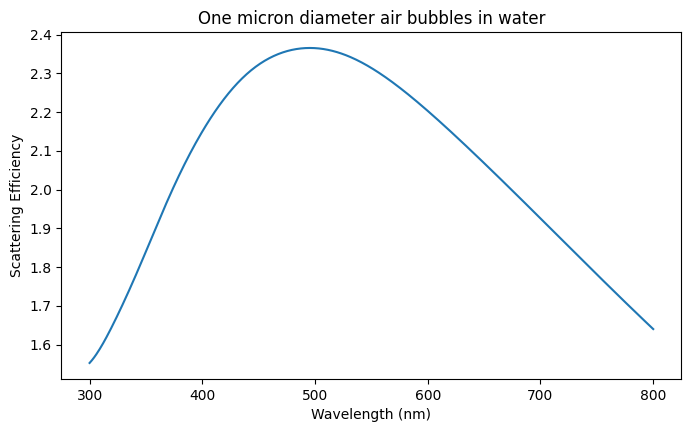

In [12]:
N = 500
mm = 1.0
r = 500  # nm
lambdaa = np.linspace(300, 800, N)  # also in nm

mwater = 4 / 3  # rough approximation
m = mm / mwater
x = 2 * np.pi * r * mwater / lambdaa

qext, qsca, qback, g = mie.efficiencies_mx(m, x)

plt.figure(figsize=(8, 4.5))
plt.plot(lambdaa, qsca)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Scattering Efficiency")
plt.title("One micron diameter air bubbles in water")
plt.show()

or you can just use `mie.efficiencies(m_sphere, d_sphere, lambda_vac, n_environ)`

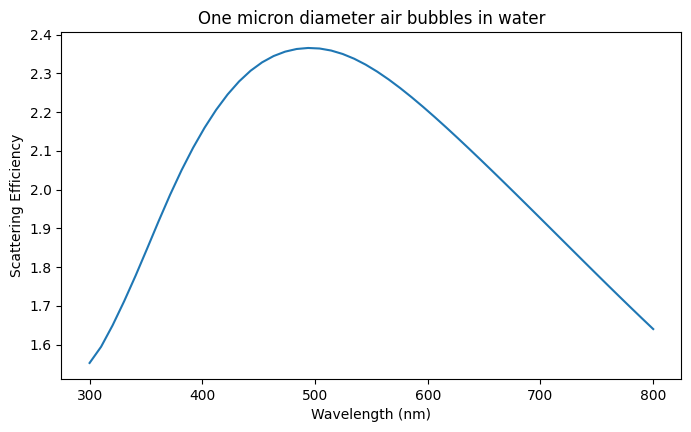

In [10]:
m_sphere = 1.0
n_water = 4 / 3
d = 1000  # nm
lambda0 = np.linspace(300, 800)  # nm

qext, qsca, qback, g = mie.efficiencies(m_sphere, d, lambda0, n_water)

plt.plot(lambda0, qsca)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Scattering Efficiency")
plt.title("One micron diameter air bubbles in water")
plt.show()

## Multiple scatterers

This will eventually turn into a description of the scattering coefficient.

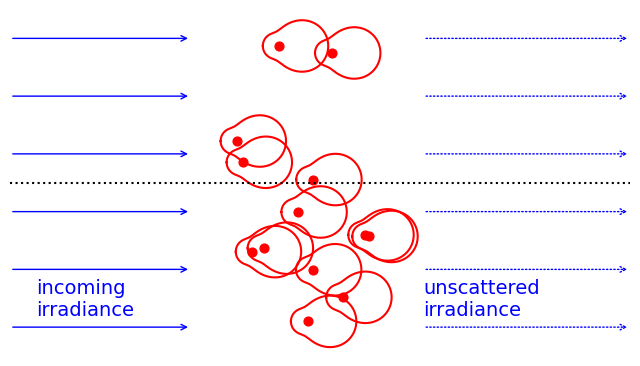

In [13]:
m = 1.5
x = np.pi / 3
theta = np.linspace(-180, 180, 1800)
mu = np.cos(theta / 180 * np.pi)
s1, s2 = mie.S1_S2(m, x, mu)
scat = 5 * (abs(s1) ** 2 + abs(s2) ** 2) / 2  # unpolarized scattered light

N = 13
xx = 3.5 * np.random.rand(N, 1) - 1.5
yy = 5 * np.random.rand(N, 1) - 2.5

plt.figure(figsize=(8, 4.5))
plt.scatter(xx, yy, s=40, color="red")
for i in range(N):
    plt.plot(
        scat * np.cos(theta / 180 * np.pi) + xx[i],
        scat * np.sin(theta / 180 * np.pi) + yy[i],
        color="red",
    )

plt.plot([-5, 7], [0, 0], ":k")

plt.annotate("incoming\nirradiance", xy=(-4.5, -2.3), ha="left", color="blue", fontsize=14)
for i in range(6):
    y0 = i - 2.5
    plt.annotate(
        "",
        xy=(-1.5, y0),
        xytext=(-5, y0),
        arrowprops=dict(arrowstyle="->", color="blue"),
    )

plt.annotate("unscattered\nirradiance", xy=(3, -2.3), ha="left", color="blue", fontsize=14)
for i in range(6):
    y0 = i - 2.5
    plt.annotate(
        "",
        xy=(7, y0),
        xytext=(3, y0),
        arrowprops=dict(arrowstyle="->", color="blue", ls=":"),
    )

# plt.annotate('scattered\nspherical\nwave', xy=(0,1.5),ha='left',color='red',fontsize=16)
# plt.annotate('',xy=(2.5,2.5),xytext=(0,0),arrowprops=dict(arrowstyle="->",color='red'))
# plt.annotate(r'$\theta$',xy=(2,0.7),color='red',fontsize=14)
# plt.annotate('',xy=(2,2),xytext=(2.7,0),arrowprops=dict(connectionstyle="arc3,rad=0.2", arrowstyle="<->",color='red'))

plt.xlim(-5, 7)
plt.ylim(-3, 3)
plt.axis("off")
plt.show()